In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# What??
Enchanced JPEG compression using Deep Residual Network. 

# Why??
Traditional JPEG compression methods rely on keeping both DC and AC coefficients, which increases transmission size. Reducing data transmission while maintaining image quality is crucial for IoT systems with limited bandwidth and power. 

# How??
1. Signal processing-based DC recovery at the receiver's end using pixel distribution theory.
2. Enhancement using deep residual learning to improve image quality.

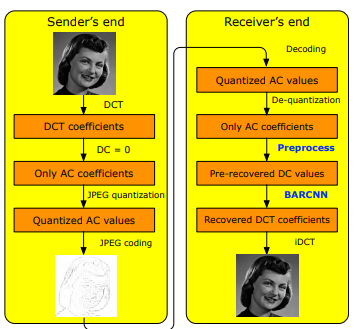


**Dataset**: MNIST Digit Dataset

In [30]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.datasets import mnist
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
x_train_resized = np.array([cv2.resize(img, (32, 32)) for img in x_train])[:10000]
x_test_resized = np.array([cv2.resize(img, (32, 32)) for img in x_test])[:2000]

In [5]:
patch_size = 8
image_shape = (32, 32) 
[w, h] = image_shape
w_n = w // patch_size
h_n = h // patch_size
DC_range = np.arange(-64, 65)

In [6]:
# Quantization table
Q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
              [12, 12, 14, 19, 26, 58, 60, 55],
              [14, 13, 16, 24, 40, 57, 69, 56],
              [14, 17, 22, 29, 51, 87, 80, 62],
              [18, 22, 37, 56, 68, 109, 103, 77],
              [24, 35, 55, 64, 81, 104, 113, 92],
              [49, 64, 78, 87, 103, 121, 120, 101],
              [72, 92, 95, 98, 112, 100, 130, 99]])

In [7]:
def dct_transform(image, mode='compress', dc_free=False):
    """
    Calculate DCT coefficients of an image.
    :param image: ndarray, input image
    :param mode: string, compression or normal mode
    :param dc_free: boolean, option whether DC coefficient is missing
    :return: dct_coefs
    """
    
    dct_coefs = np.zeros([w_n, h_n, patch_size, patch_size])
    image = image - 128 * np.ones([w, h])
    
    for i in range(w_n):
        for j in range(h_n):
            image_patch = image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
            dct = cv2.dct(image_patch)
            if dc_free:
                dct[0][0] = 0.  # Set DC component to zero when dc_free is True
            
            if mode == 'compress':
                dct_coefs[i, j] = np.round(dct / Q)  # Apply quantization for compression
            elif mode == 'normal':
                dct_coefs[i, j] = dct  # No quantization, normal DCT
            
    return dct_coefs


In [8]:
def dc_recovery(image):
    """
    Recover the DC components of the image using block predictions.
    :param image: Input image
    :return: Recovered image
    """
    dct_coefs = dct_transform(image, dc_free=True)  # Compute DCT without DC
    dct_coefs_with_dc = dct_transform(image, dc_free=False)  # Get original DCT for corner blocks
    
    # Preset DC from corner blocks
    dc_preset = [dct_coefs_with_dc[0, 0, 0, 0], dct_coefs_with_dc[0, h_n-1, 0, 0],
                 dct_coefs_with_dc[w_n-1, 0, 0, 0], dct_coefs_with_dc[w_n-1, h_n-1, 0, 0]]
    
    # Predict DC components for all blocks
    dct_preds = dc_prediction(dct_coefs, dc_preset[0])  # Predict DC coefficients
    
    # Reconstruct the image from the predicted DCT coefficients
    recovered_image = recover_from_dct(dct_preds, mode='compress')
    
    return recovered_image


In [10]:
def estimate(dct_target, dct_left=False, dct_up=False, dct_right=False, dct_down=False):
    """
    Estimation of DCT coefficients with the help of adjacent blocks.
    :param dct_target: ndarray, DCT of target block
    :param dct_left: ndarray, DCT of left block
    :param dct_up: ndarray, DCT of upper block
    :param dct_right: ndarray, DCT of right block
    :param dct_down: ndarray, DCT of nether block
    :return: dc_optimal: float, optimal value of DC prediction
    """
    
    mse_min = np.inf
    dc_optimal = 0.
    if dct_left is not False:
        spatial_left = cv2.idct(dct_left * Q) + 128
    if dct_up is not False:
        spatial_up = cv2.idct(dct_up * Q) + 128
    if dct_right is not False:
        spatial_right = cv2.idct(dct_right * Q) + 128
    if dct_down is not False:
        spatial_down = cv2.idct(dct_down * Q) + 128
        
    for dc in DC_range:
        mse1 = 0.
        mse2 = 0.
        mse3 = 0.
        dct_target[0, 0] = dc
        spatial_target = cv2.idct(dct_target * Q) + 128
        if dct_left is not False:
            mse1 += np.sum(np.square((spatial_left[0:8, 7] - spatial_target[0:8, 0]) -
                                     (spatial_left[0:8, 6] - spatial_left[0:8, 7]))) / 8
            mse2 += np.sum(np.square((spatial_left[0:7, 7] - spatial_target[1:8, 0]) -
                                     (spatial_left[0:7, 6] - spatial_left[1:8, 7]))) / 7
            mse3 += np.sum(np.square((spatial_left[1:8, 7] - spatial_target[0:7, 0]) -
                                     (spatial_left[1:8, 6] - spatial_left[0:7, 7]))) / 7
        if dct_up is not False:
            mse1 += np.sum(np.square((spatial_up[7, 0:8] - spatial_target[0, 0:8]) -
                                     (spatial_up[6, 0:8] - spatial_up[7, 0:8]))) / 8
            mse2 += np.sum(np.square((spatial_up[7, 0:7] - spatial_target[0, 1:8]) -
                                     (spatial_up[6, 0:7] - spatial_up[7, 1:8]))) / 7
            mse3 += np.sum(np.square((spatial_up[7, 1:8] - spatial_target[0, 0:7]) -
                                     (spatial_up[6, 1:8] - spatial_up[7, 0:7]))) / 7
        if dct_right is not False:
            mse1 += np.sum(np.square((spatial_right[0:8, 0] - spatial_target[0:8, 7]) -
                                     (spatial_right[0:8, 1] - spatial_right[0:8, 0]))) / 8
            mse2 += np.sum(np.square((spatial_right[0:7, 0] - spatial_target[1:8, 7]) -
                                     (spatial_right[0:7, 1] - spatial_right[1:8, 0]))) / 7
            mse3 += np.sum(np.square((spatial_right[1:8, 0] - spatial_target[0:7, 7]) -
                                     (spatial_right[1:8, 1] - spatial_right[0:7, 0]))) / 7
        if dct_down is not False:
            mse1 += np.sum(np.square((spatial_down[0, 0:8] - spatial_target[7, 0:8]) -
                                     (spatial_down[1, 0:8] - spatial_down[0, 0:8]))) / 8
            mse2 += np.sum(np.square((spatial_down[0, 0:7] - spatial_target[7, 1:8]) -
                                     (spatial_down[1, 0:7] - spatial_down[0, 1:8]))) / 7
            mse3 += np.sum(np.square((spatial_down[0, 1:8] - spatial_target[7, 0:7]) -
                                     (spatial_down[1, 1:8] - spatial_down[0, 0:7]))) / 7
        mse = np.min([mse1, mse2, mse3])
        if mse < mse_min:
            mse_min = mse
            dc_optimal = dc

    return dc_optimal

In [11]:
def recover_from_dct(dct_coefs, mode='compress'):
    """
    Reconstruct the image from DCT coefficients.
    :param dct_coefs: DCT coefficients
    :param mode: compress or normal
    :return: Recovered image
    """
    
    image_rec = np.zeros(image_shape)
    
    if mode == 'normal':
        for i in range(w_n):
            for j in range(h_n):
                idct = cv2.idct(dct_coefs[i, j])
                image_rec[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = idct + 128
    elif mode == 'compress':
        for i in range(w_n):
            for j in range(h_n):
                idct = cv2.idct(dct_coefs[i, j] * Q)
                image_rec[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = idct + 128
    
    return image_rec


In [12]:
def dc_prediction(dct_coefs, dc_preset):
    """
    DC coefficients prediction from up-left to right-down.
    :param dct_coefs: ndarray, DCT coefficients of blocks
    :param dc_preset: float, preset dc value of reference block
    :return: dct_preds: ndarray, estimated DCT coefficients of blocks
    """

    dct_preds = np.zeros([w_n, h_n, patch_size, patch_size])
    dct_preds[0, 0, 0, 0] = dc_preset
    
    for i in range(w_n):
        for j in range(h_n):
            dct_target = dct_coefs[i, j]
            if i == 0 and j == 0:
                dct_target[0, 0] = dct_preds[i, j, 0, 0]
                dct_preds[i, j] = dct_target
                continue
            if j == 0:
                dct_up = dct_coefs[i - 1, j]
                dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up)
            else:
                dct_left = dct_coefs[i, j - 1]
                dct_left[0, 0] = dct_preds[i, j - 1, 0, 0]
                if i == 0:
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_left=dct_left)
                else:
                    dct_up = dct_coefs[i - 1, j]
                    dct_up[0, 0] = dct_preds[i - 1, j, 0, 0]
                    dct_target[0, 0] = estimate(dct_target=dct_target, dct_up=dct_up, dct_left=dct_left)
            dct_preds[i, j] = dct_target

    return dct_preds

In [13]:
def preprocess_data_with_dc(images):
    compressed_images = []
    original_images = []

    for image in images:
        recovered_image = dc_recovery(image)

        recovered_image = recovered_image / 255.0
        image = image / 255.0

        compressed_images.append(recovered_image)
        original_images.append(image)

    return np.array(compressed_images), np.array(original_images)

In [14]:
x_train_compressed, x_train_original = preprocess_data_with_dc(x_train_resized)
x_test_compressed, x_test_original = preprocess_data_with_dc(x_test_resized)

In [15]:
from tensorflow.keras import layers, models

In [16]:
def BARCNN():
  input_layer = layers.Input(shape=(32, 32, 1))


  # First residual
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)

  for _ in range(11):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

  first_residual = layers.Conv2D(1, (3, 3), padding='same')(x)

  # Second residual
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(first_residual)

  for _ in range(11):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

  second_residual = layers.Conv2D(1, (3, 3), padding='same')(x)


  output_layer = layers.Add()([first_residual, second_residual, input_layer])

  model = models.Model(inputs=input_layer, outputs=output_layer)

  return model


In [17]:
model = BARCNN()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     36,928 │ batch_normalizat

 Total params: 820,482 (3.13 MB)

 Trainable params: 817,666 (3.12 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [18]:
x_train_compressed = x_train_compressed.reshape(-1, 32, 32, 1)
x_train_original = x_train_original.reshape(-1, 32, 32, 1)

x_test_compressed = x_test_compressed.reshape(-1, 32, 32, 1)
x_test_original = x_test_original.reshape(-1, 32, 32, 1)

In [35]:
history = model.fit(x_train_compressed, x_train_original, validation_data=(x_test_compressed, x_test_original), epochs=50, batch_size=64)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0022 - val_loss: 0.0220
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0014 - val_loss: 0.0669
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0012 - val_loss: 9.2878e-04
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0101 - val_loss: 0.0249
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━

In [36]:
model.save('/kaggle/working/model.keras')

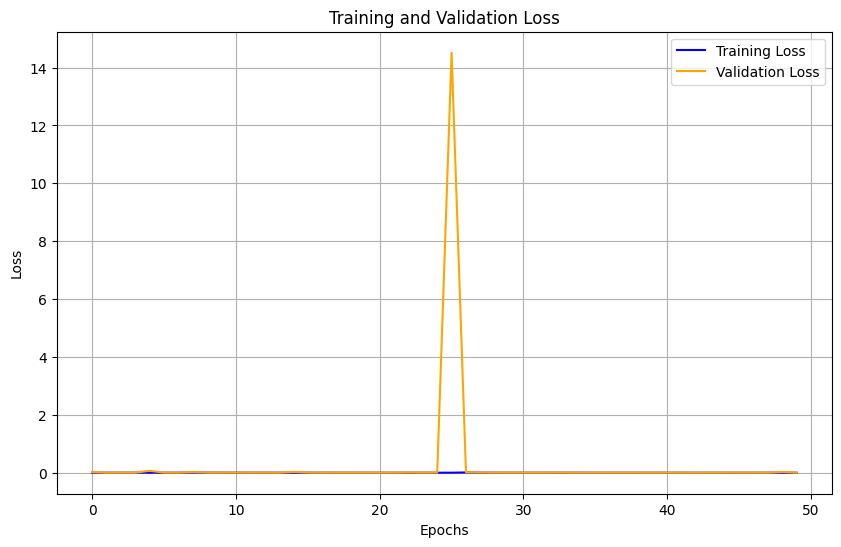

In [37]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [38]:
def plot_images(original, compressed, recovered):
    plt.figure(figsize=(10, 3))
    for i in range(5):
        # Original images
        plt.subplot(3, 5, i + 1)
        plt.imshow(original[i].reshape(32, 32), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # Compressed images (with AC only)
        plt.subplot(3, 5, i + 6)
        plt.imshow(compressed[i].reshape(32, 32), cmap='gray')
        plt.title('DC Recovered')
        plt.axis('off')

        # Recovered images
        plt.subplot(3, 5, i + 11)
        plt.imshow(recovered[i].reshape(32, 32), cmap='gray')
        plt.title('Recovered')
        plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


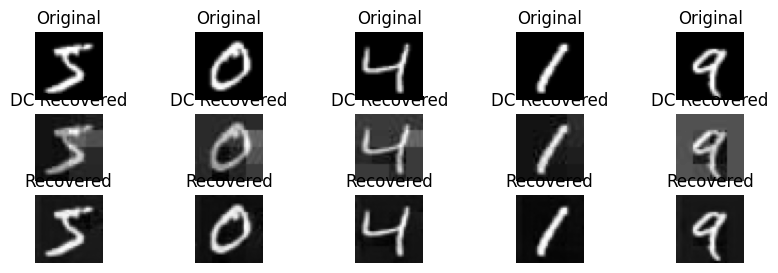

In [39]:
recovered_images = model.predict(x_train_compressed[:10])

plot_images(x_train_original[:10], x_train_compressed[:10], recovered_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


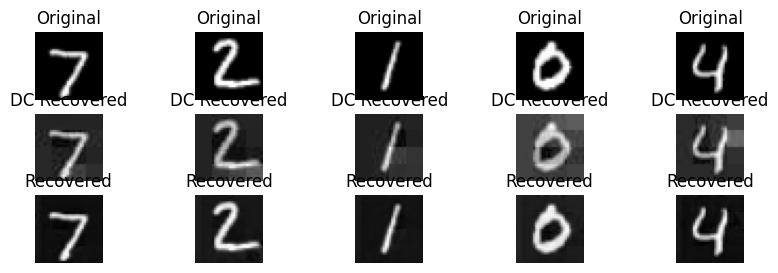

In [40]:
recovered_images = model.predict(x_test_compressed[:10])

plot_images(x_test_original[:10], x_test_compressed[:10], recovered_images)

In [41]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Function to compute PSNR and SSIM between two images
def evaluate_image_quality(original, compressed):
    # Calculate PSNR
    psnr_value = psnr(original, compressed, data_range=compressed.max() - compressed.min())

    # Calculate SSIM
    ssim_value, _ = ssim(original, compressed, full=True, data_range=compressed.max() - compressed.min())

    return psnr_value, ssim_value

In [42]:
import cv2

def compress_with_jpeg(image, quality=50):
    # Convert image to a valid format for JPEG compression (uint8)
    image_uint8 = (image * 255).astype(np.uint8)

    # Compress the image to JPEG format
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    result, enc_img = cv2.imencode('.jpg', image_uint8, encode_param)

    # Decode the image back to simulate decompression
    dec_img = cv2.imdecode(enc_img, 0)  # Read as grayscale

    return dec_img / 255.0  # Normalize to range [0, 1]

In [43]:
# Perform custom compression (Deep Residual Learning) on the test images
recovered_images = model.predict(x_test_compressed)

# Perform standard JPEG compression on the test images
jpeg_compressed_images = [compress_with_jpeg(img, quality=50) for img in x_test_original]

# Evaluate and compare quality (PSNR and SSIM) between approaches
def compare_approaches(original_images, recovered_images, jpeg_images):
    psnr_custom, ssim_custom = 0, 0
    psnr_jpeg, ssim_jpeg = 0, 0

    for i in range(len(original_images)):
        original = original_images[i].reshape(32, 32)
        recovered = recovered_images[i].reshape(32, 32)
        jpeg = jpeg_images[i].reshape(32, 32)

        # Evaluate the custom deep learning approach
        psnr_c, ssim_c = evaluate_image_quality(original, recovered)
        psnr_custom += psnr_c
        ssim_custom += ssim_c

        # Evaluate the standard JPEG compression
        psnr_j, ssim_j = evaluate_image_quality(original, jpeg)
        psnr_jpeg += psnr_j
        ssim_jpeg += ssim_j

    # Average the results
    psnr_custom /= len(original_images)
    ssim_custom /= len(original_images)
    psnr_jpeg /= len(original_images)
    ssim_jpeg /= len(original_images)

    print(f"Custom Compression: PSNR = {psnr_custom:.2f}, SSIM = {ssim_custom:.4f}")
    print(f"Standard JPEG Compression: PSNR = {psnr_jpeg:.2f}, SSIM = {ssim_jpeg:.4f}")

# Compare approaches
compare_approaches(x_test_original, recovered_images, np.array(jpeg_compressed_images).reshape(-1, 32, 32, 1))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Custom Compression: PSNR = 32.27, SSIM = 0.8756
Standard JPEG Compression: PSNR = 33.38, SSIM = 0.9487


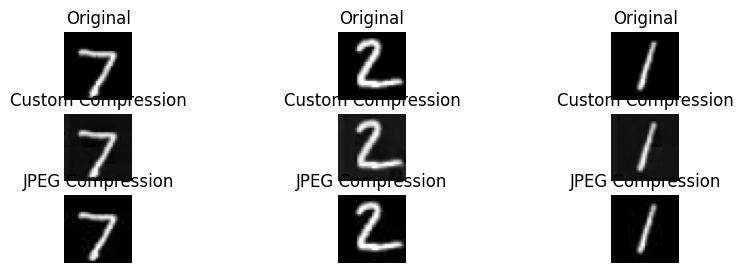

In [44]:
def plot_comparison(original, custom_recovered, jpeg_recovered):
    plt.figure(figsize=(10, 3))
    for i in range(3):
        # Original image
        plt.subplot(3, 3, i + 1)
        plt.imshow(original[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Custom compression (Deep Residual Learning)
        plt.subplot(3, 3, i + 4)
        plt.imshow(custom_recovered[i].reshape(32, 32), cmap='gray')
        plt.title("Custom Compression")
        plt.axis('off')

        # JPEG compression
        plt.subplot(3, 3, i + 7)
        plt.imshow(jpeg_recovered[i].reshape(32, 32), cmap='gray')
        plt.title("JPEG Compression")
        plt.axis('off')

    plt.show()

# Visual comparison
plot_comparison(x_test_original[:3], recovered_images[:3], np.array(jpeg_compressed_images[:3]).reshape(-1, 32, 32, 1))

In [45]:
def calculate_compression_ratio_custom(images):
    total_original_size = 0
    total_compressed_size = 0

    for image in images:
        dct_coefs = dct_transform(image, dc_free=True)
        compressed_size = np.count_nonzero(dct_coefs)
        total_compressed_size += compressed_size
        total_original_size += image.size  # Original image size

    compression_ratio = total_original_size / total_compressed_size
    return compression_ratio

def calculate_compression_ratio_jpeg(images):
    total_original_size = 0
    total_compressed_size = 0

    for image in images:
        _, jpeg_encoded = cv2.imencode('.jpg', image)
        compressed_size = len(jpeg_encoded)
        total_compressed_size += compressed_size
        total_original_size += image.size  # Original image size

    compression_ratio = total_original_size / total_compressed_size
    return compression_ratio

x_train_resized_255 = x_train_resized

# Custom method compression ratio
custom_ratio = calculate_compression_ratio_custom(x_train_resized_255)

# Standard JPEG compression ratio
jpeg_ratio = calculate_compression_ratio_jpeg(x_train_resized_255)

# Print comparison
print(f"Custom Method Compression Ratio: {custom_ratio:.2f}")
print(f"Standard JPEG Compression Ratio: {jpeg_ratio:.2f}")


Custom Method Compression Ratio: 5.36
Standard JPEG Compression Ratio: 1.31


In [46]:
compression_improvement = ((custom_ratio - jpeg_ratio) / jpeg_ratio) * 100

print(f"Custom Method provides {compression_improvement:.2f}% more compression compared to JPEG.")

Custom Method provides 309.62% more compression compared to JPEG.
